# Multigroup Nilgai Camera Trap Classifier
This notebook walks through the process of using a trained convolutional neural network (CNN) to make predictions on camera trap  images.

In [1]:
# Import libraries and dependencies
import os
import sys
import tensorflow as tf 
import tensorflow_hub as hub 
import numpy as np 
import pandas as pd
from sklearn import metrics
import shutil
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Directory to trained model
MODEL_PATH  = os.path.join(ROOT_DIR,'model/multi_nil_100K_89acc.h5')
# Directory to place predictions into class sub-directorie
RESULTS_DIR = os.path.join(ROOT_DIR,'results')
# Directory of images to run classification on
IMAGE_DIR = os.path.join(ROOT_DIR,'images')

# Set model prediction settings
BATCH_SIZE = 1
IMG_HEIGHT = 299
IMG_WIDTH = 299

## Load model, make predictions, and organize images by class.

In [2]:
def img_crop(img):
    # Crop image to remove datetime info and camera logo
    new_img = tf.image.crop_to_bounding_box(img, 9, 0, 273, 299) 
    new_img = tf.image.resize(new_img, (299,299))
    return new_img

# Create data input pipeline
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=img_crop)

test_generator = img_generator.flow_from_directory(
                        directory=str(IMAGE_DIR), 
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        target_size=(IMG_HEIGHT,IMG_WIDTH), 
                        class_mode= None)
# Load model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'KerasLayer':hub.KerasLayer}, compile=True)


Found 222 images belonging to 1 classes.


In [3]:
# Define class names and create and index for mapping
CLASS_NAMES = [('Armadillo', 0),
    ('Birds', 1),
    ('Cat', 2),
    ('Cattle', 3),
    ('Coyote', 4),
    ('Dog', 5),
    ('Horse', 6),
    ('Humans', 7),
    ('Mouse', 8),
    ('Nilgai', 9),
    ('None', 10),
    ('Opossum', 11),
    ('Pig', 12),
    ('Rabbit', 13),
    ('Raccoon', 14),
    ('Rat', 15),
    ('Skunk', 16),
    ('Spider', 17),
    ('Tortoise', 18),
    ('Turkey', 19),
    ('White-tailed Deer', 20)]

In [4]:
# Make predictions
pred_steps=np.ceil(test_generator.samples/test_generator.batch_size)

pred = model.predict(test_generator, verbose=1, workers=2, steps=pred_steps)

222/222 [==============================] - 25s 112ms/step


In [5]:
# Define class names and create and index for mapping
class_names_dict = CLASS_NAMES
# Get classname and index information from list
class_names = np.array([key.title() for key, value in class_names_dict])
predicted_id = np.argmax(pred, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [6]:
# Check directories and create folders by class
for i in class_names:
    img_path = os.path.join(RESULTS_DIR, str(i))
    try:
        os.makedirs(img_path, exist_ok=False)
    except:
        print("The " + '"' + str(i) + '"' + " folder already exists.\nYou might have already run the previous notebook. Go into the /results \nfolder and either delete or move the images folders that have already been created.")

In [7]:
# Map predictions to labels and move images to respective folders
img_src_path = []
img_n = []
classes = []
classes_idx = []
for i, logits in enumerate(pred):
    class_idx = tf.argmax(logits).numpy()
    classes_idx.append(class_idx)
    name = class_names[class_idx]
    classes.append(name)
    img_name = os.path.split(test_generator.filenames[i])[1]
    samp_name = os.path.splitext(img_name)[0]
    img = os.path.join(IMAGE_DIR+"/images",img_name)
    dst = os.path.join(RESULTS_DIR, name)
    img_path = os.path.join(dst,img)
    shutil.copy(img, dst)
    img_src_path.append(img_path)
    img_n.append(img_name)


## Visualize Results

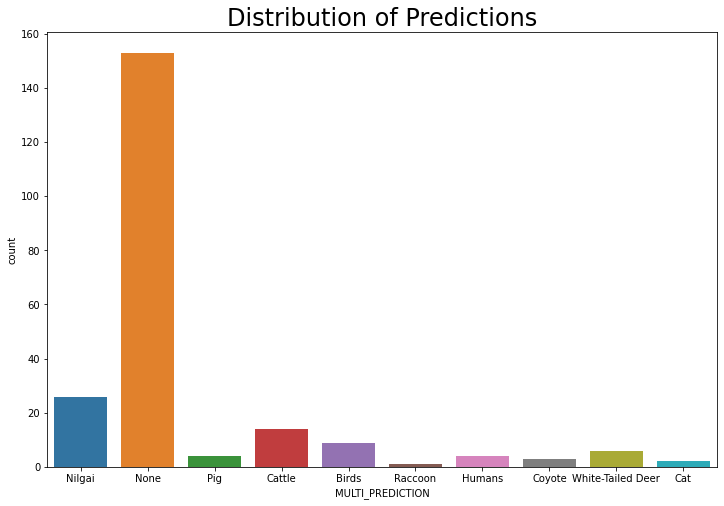

In [8]:
# create dataframe of results and load true image labels for accuracy assessment. 
df_pred =pd.DataFrame({'IMGPATH':img_src_path,'IMGNAME':img_n, 'PREDICTION_ID':classes_idx, 'MULTI_PREDICTION':classes})

df_true = pd.read_csv('image_labels.csv')

# Visualize prediction output class distribution
def show_dist(df, class_names):
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.countplot(x="MULTI_PREDICTION", data=df)
    ax.set_title("Distribution of Predictions", fontsize=24)
    plt.show()

show_dist(df_pred, class_names)

## Show random sample of predicitons

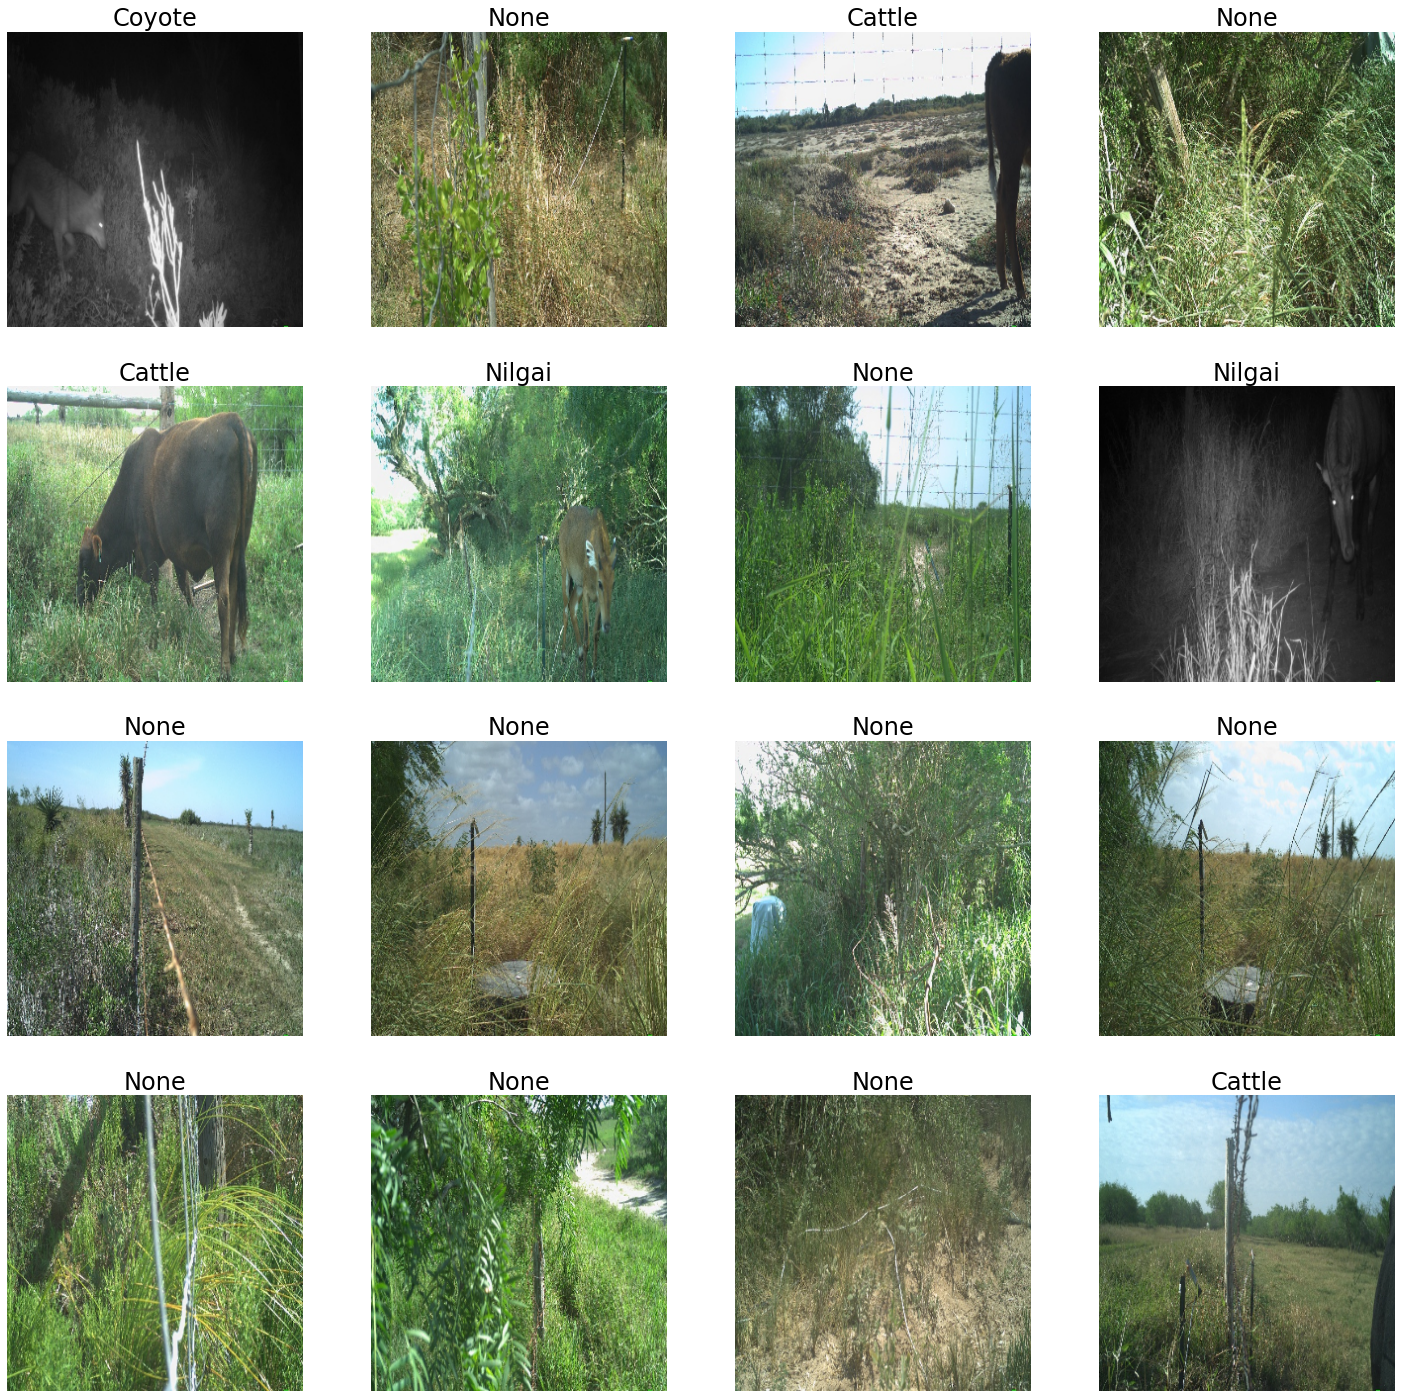

In [9]:
# Visualize prediction results
df = df_pred.sample(20)
img_list = []
for row in df.itertuples():
    img = cv2.imread(row.IMGPATH)
    newimage = cv2.resize(img,(299,299))
    img_list.append(newimage)

plt.figure(figsize=(25,25))
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(cv2.cvtColor(img_list[n], cv2.COLOR_BGR2RGB))
    plt.title(df['MULTI_PREDICTION'].iloc[n], fontdict={'fontsize':24})
    plt.axis('off')

plt.show()

## Evaluate Results

In [10]:
# Assess accuracy by comparing predictions to true labels
# Merge dataframes
df_new = df_true.join(df_pred.set_index('IMGNAME'), on='IMGNAME')
print(metrics.classification_report(df_new['MULTI_LABEL'], df_new['MULTI_PREDICTION']))

                   precision    recall  f1-score   support

            Birds       0.78      0.78      0.78         9
              Cat       0.00      0.00      0.00         0
           Cattle       0.93      0.93      0.93        14
           Coyote       0.67      1.00      0.80         2
           Humans       0.25      1.00      0.40         1
           Nilgai       0.96      0.76      0.85        33
             None       0.99      0.97      0.98       156
              Pig       0.50      1.00      0.67         2
          Raccoon       1.00      1.00      1.00         1
White-Tailed Deer       0.50      0.75      0.60         4

         accuracy                           0.92       222
        macro avg       0.66      0.82      0.70       222
     weighted avg       0.95      0.92      0.93       222



c:\users\mkutu\desktop\nilgai\niltest\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Go to the /results folder to see the sorted images